Exploration of UCI Breast Cancer Diagnostic Data
================================================

Looking at the breast cancer data and exploring the dataset.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer

In [2]:
cancer = load_breast_cancer()

print(cancer.keys(), cancer.target_names, cancer.feature_names, len(cancer.feature_names), sep='\n')

dict_keys(['DESCR', 'data', 'target', 'target_names', 'feature_names'])
['malignant' 'benign']
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
30


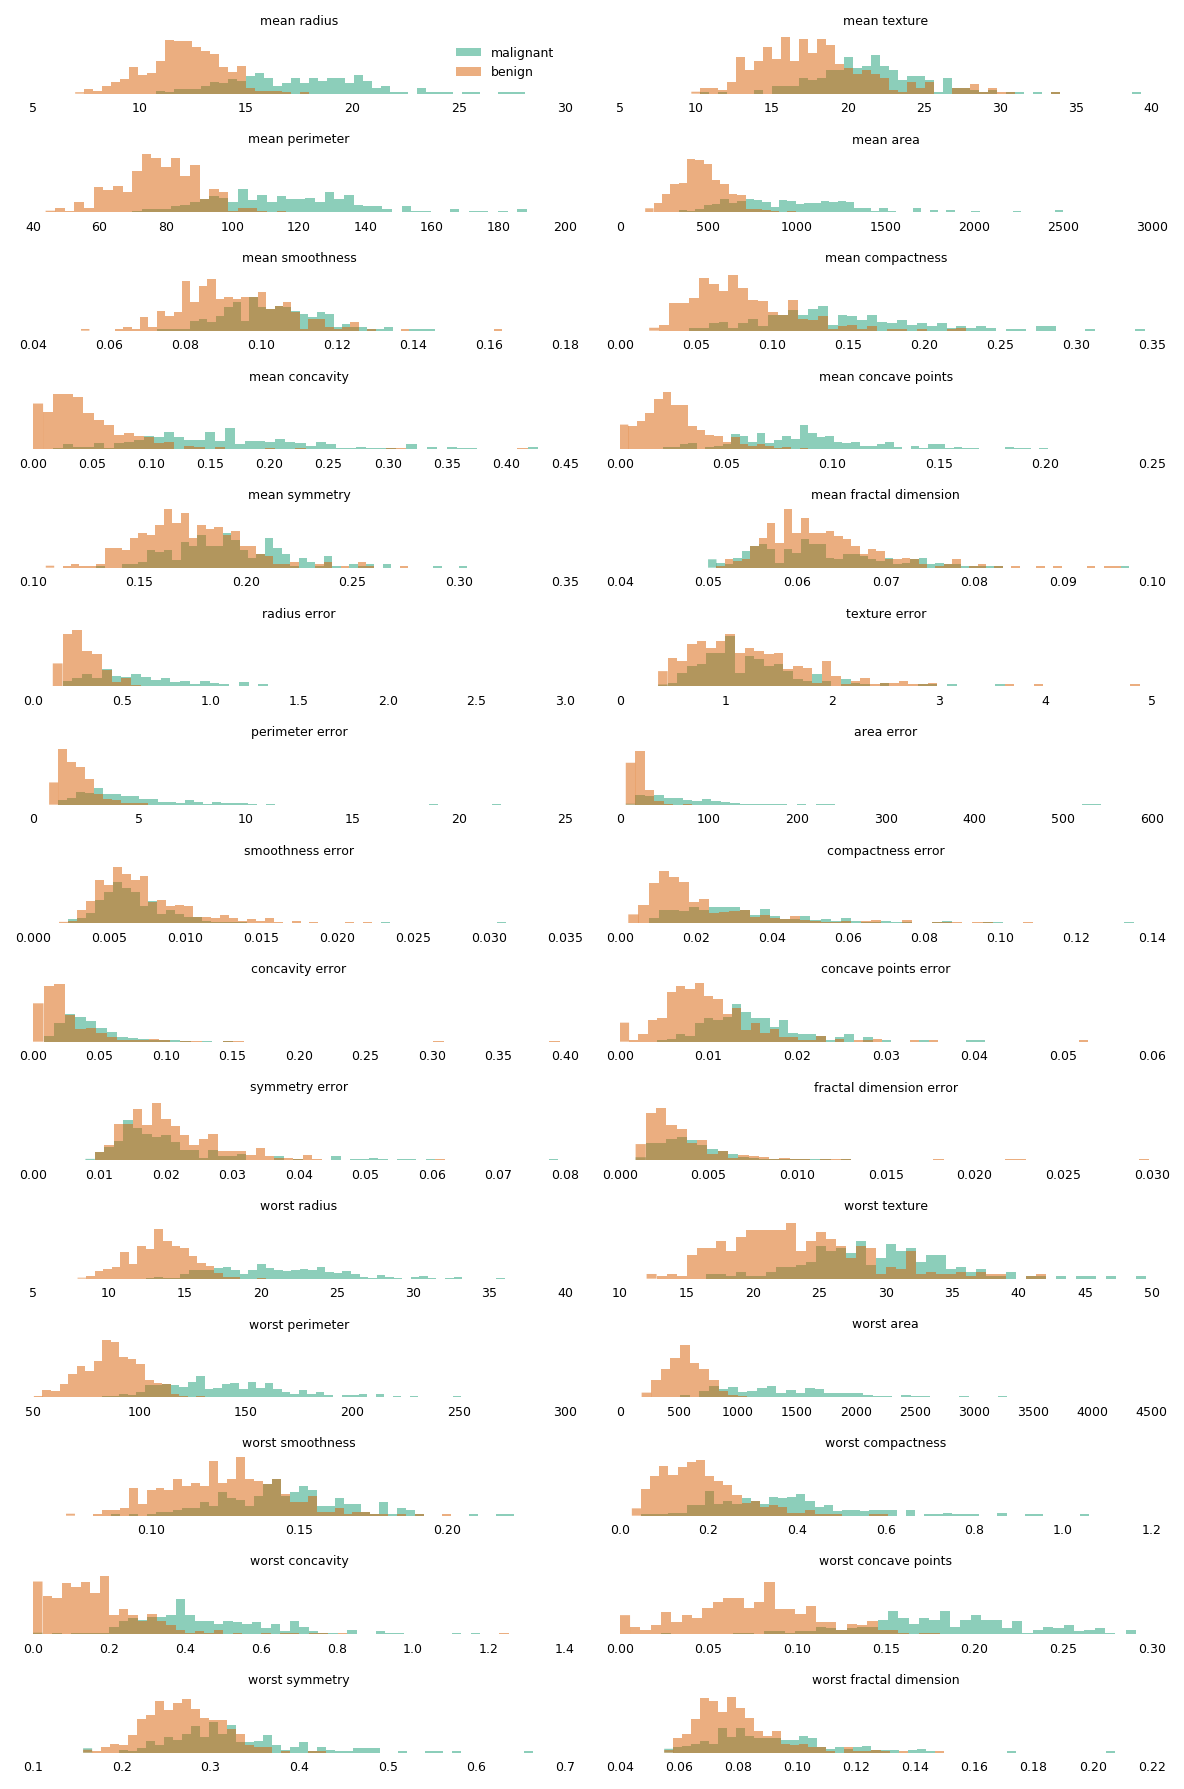

In [3]:
fig, axes = plt.subplots(nrows=15, ncols=2, figsize=(8, 12))
ax = axes.ravel()

malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]

for i, (axis, name) in enumerate(zip(ax, cancer.feature_names)):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    axis.hist(malignant[:, i], bins=bins, alpha=0.5, linewidth=0)
    axis.hist(benign[:, i], bins=bins, alpha=0.5, linewidth=0)
    axis.set_title(name, fontdict={'fontsize': 6})
    for _, spine in axis.spines.items():
        spine.set_visible(False)
    axis.set_yticks(())
    axis.tick_params(bottom='off', top='off', left='off', right='off', labelsize=6)
fig.tight_layout()

ax[0].legend(['malignant', 'benign'], loc='best', fontsize=6, frameon=False)
plt.show()

Looking at the above, we can see a few features that we could use to discriminate between malignant and benign tumors. Any classification will probably use a combination of those features to classify the data.

Before we move on, we need to standardize our data so that the scalings don't skew the model, and split it to avoid our training data knowing about the test data.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_holdout, y_train, y_holdout = train_test_split(cancer.data, cancer.target, random_state=20150808)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_holdout_std = scaler.transform(X_holdout)

We need to look at potential classifiers. The malignant/benign cases appear to be roughly linearly separable, so we shouldn't need to do anything too crazy.

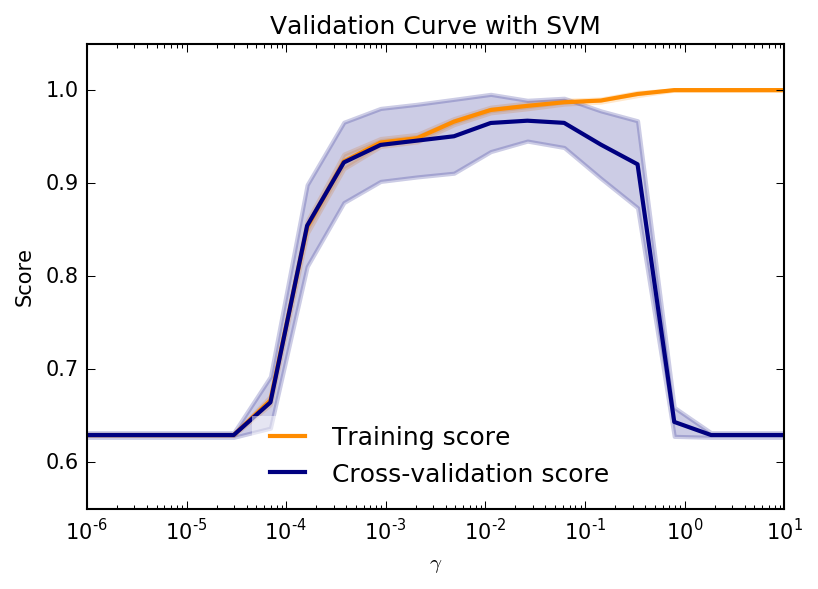

In [17]:
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC

param_range = np.logspace(-6, 1, 20)
train_scores, test_scores = validation_curve(
    SVC(), X_train_std, y_train, param_name='gamma', param_range=param_range,
    cv=10, scoring='accuracy', n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation Curve with SVM')
plt.xlabel('$\gamma$')
plt.ylabel("Score")
plt.ylim(0.55, 1.05)
lw = 2
plt.semilogx(param_range, train_scores_mean, label='Training score',
             lw=lw, color='darkorange')
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 lw=lw, color='darkorange')
plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
             lw=lw, color='navy')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 lw=lw, color='navy')
plt.legend(loc='lower center', framealpha=0.5)
plt.show()

In [21]:
from sklearn.model_selection import cross_val_score

svc = SVC(probability=True, gamma=1e-2)
scores = cross_val_score(svc, X_train_std, y_train, cv=10)
svc.fit(X_train_std, y_train)
test_scores = svc.predict(X_holdout_std) == y_holdout

print('Accuracy: {:.2f} (+/- {:.2f})'.format(scores.mean(), scores.std() * 2))
print('Test accuracy: {:.2f}'.format(test_scores.mean()))

Accuracy: 0.96 (+/- 0.06)
Test accuracy: 0.99


In [22]:
from sklearn.gaussian_process import GaussianProcessClassifier

gpc = GaussianProcessClassifier()
scores = cross_val_score(gpc, X_train_std, y_train, cv=10)
gpc.fit(X_train_std, y_train)
test_scores = gpc.predict(X_holdout_std) == y_holdout

print('Accuracy: {:.2f} (+/- {:.2f})'.format(scores.mean(), scores.std() * 2))
print('Test accuracy: {:.2f}'.format(test_scores.mean()))

Accuracy: 0.96 (+/- 0.08)
Test accuracy: 0.98


In [23]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
scores = cross_val_score(nb, X_train_std, y_train, cv=10)
nb.fit(X_train_std, y_train)
test_scores = nb.predict(X_holdout_std) == y_holdout

print('Accuracy: {:.2f} (+/- {:.2f})'.format(scores.mean(), scores.std() * 2))
print('Test accuracy: {:.2f}'.format(test_scores.mean()))

Accuracy: 0.92 (+/- 0.09)
Test accuracy: 0.96


To get a better understanding of our classifiers, we can look at the ROC (Receiver Operating Characteristic) for these three models, since they are all decently close to what we would want. Since our models are already trained (and for the SVC, optimized), we can plot all of them on the same plot.

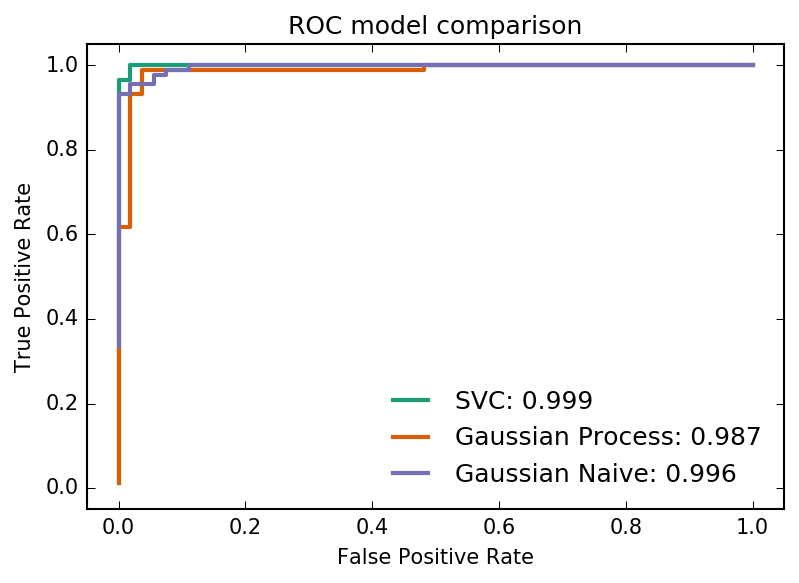

In [26]:
from sklearn.metrics import roc_curve, auc

models = [svc, gpc, nb]
model_names = ['SVC', 'Gaussian Process', 'Gaussian Naive']

for model, model_name in zip(models, model_names):
    probas_ = model.predict_proba(X_holdout_std)
    fpr, tpr, _ = roc_curve(y_holdout, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='{}: {:.3f}'.format(model_name, roc_auc))
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC model comparison')
plt.legend(loc='lower right')
plt.show()

So, all three of these classifiers perform very well on this dataset, as expected. The support vector model was optimized using the data, but that should not have played too much of a role in its final outcome. Most datasets would not be this easy to separate.

Dimension Reduction
-------------------

Since this datset has 30 features, we could consider doing some dimensionality reduction. We saw from our plots that some of the features display better separation between the malignant and benign tumors (e.g. mean concave points) that could capture enough of the disparity between the two classes.